In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.nn as nn
import torch

# official pretrain weights
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
}


class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.features(x)
        # N x 512 x 7 x 7
        x = torch.flatten(x, start_dim=1)
        # N x 512*7*7
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_features(cfg: list):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg(model_name="vgg16", **kwargs):
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    cfg = cfgs[model_name]

    model = VGG(make_features(cfg), **kwargs)
    return model

In [ ]:
import torch
import torch.nn as nn


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self,
                 block,
                 block_num,
                 num_classes=1000,
                 include_top=True):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.in_channel,
                               kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, block_num[0])
        self.layer2 = self._make_layer(block, 128, block_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, block_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, block_num[3], stride=2)

        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.normal_(m.bias, 0)

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))
        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride))
        self.in_channel = channel*block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)

def resnet18(num_classes=1000, include_top=True):
  return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, include_top=include_top)

In [ ]:
!unzip '/content/Data.zip' -d '/content'
!unzip '/content/Data_Predict_Clean.zip' -d '/content'

In [ ]:
import shutil
shutil.copy( '/content/drive/MyDrive/ResNet34.pth', '/content/ResNet34.pth')

'/content/ResNet34.pth'

In [ ]:
import os
import json
import sys
import os.path
import shutil

from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import datasets, transforms
# from model import resnet34


def main():
    # Set Device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Using {} for this project'.format(device))

    # Image_Loader and Label
    path_root = '/content/'
    image_path = os.path.join(path_root,  'Data')
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor()])}

    # Get train_set
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, 'train'),
                                         transform=data_transform['train'])
    train_num = len(train_dataset)

    # Get label
    category_to_label = train_dataset.class_to_idx
    label_to_category = dict((val, key) for key, val in category_to_label.items())

    # Write to json
    json_label = json.dumps(label_to_category, indent=4)
    with open('class_label.json', 'w') as json_file:
        json_file.write(json_label)

    # Load train_loader / val_loader
    batch_size = 64
    nw = 2
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=nw)
    batch_num = len(train_loader)

    val_dataset = datasets.ImageFolder(root=os.path.join(image_path, 'val'),
                                       transform=data_transform['val'])
    val_num = len(val_dataset)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=nw)

    # Model Initial
    # model = resnet34(num_classes=2, include_top=True).to(device)
    # model = resnet18(num_classes=2, include_top=True).to(device)
    model = vgg('vgg16', num_classes=2).to(device)
    # Load model weights
    weights_path = "./Vgg16.pth"
    # weights_path = "./Vgg11.pth"
    if os.path.exists(weights_path):
      print("Continue Trainning")
      model.load_state_dict(torch.load(weights_path,map_location=device))

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

    # Train
    epochs = 30
    best_acc = 0.0
    # save_path = "./Vgg11.pth"
    save_path = "./Vgg16.pth"
    for epoch in range(epochs):
        model.train()
        train_bar = tqdm(train_loader, file=sys.stdout)
        total_loss = 0.0
        for step, data in enumerate(train_bar):
            optimizer.zero_grad()
            img, label = data
            predict = model(img.to(device))
            loss = loss_function(predict, label.to(device))
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print('Epoch[{}/{}] train_loss:{:.3f}'.format(epoch + 1,
                                                     epochs,
                                                     total_loss))

        model.eval()
        val_bar = tqdm(val_loader, file=sys.stdout)
        acc = 0.0
        with torch.no_grad():
            for data in val_bar:
                val_img, val_label = data
                predict = model(val_img.to(device))
                output = torch.max(predict, dim=1)[1]
                acc += torch.eq(output, val_label.to(device)).sum().item()
        accuracy = acc / val_num
        val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                   epochs)
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, total_loss / batch_num, accuracy))

        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), save_path)
    shutil.copy('/content/Vgg16.pth', '/content/drive/MyDrive/Vgg16.pth')
    print('Finish Training!')


if __name__ == "__main__":
    main()

Using cuda:0 for this project
100%|██████████| 1173/1173 [16:55<00:00,  1.15it/s]
Epoch[1/30] train_loss:607.604
100%|██████████| 680/680 [03:29<00:00,  3.25it/s]
[epoch 1] train_loss: 0.518  val_accuracy: 0.947
100%|██████████| 1173/1173 [16:56<00:00,  1.15it/s]
Epoch[2/30] train_loss:197.138
100%|██████████| 680/680 [03:53<00:00,  2.91it/s]
[epoch 2] train_loss: 0.168  val_accuracy: 0.960
100%|██████████| 1173/1173 [16:58<00:00,  1.15it/s]
Epoch[3/30] train_loss:177.981
100%|██████████| 680/680 [03:50<00:00,  2.95it/s]
[epoch 3] train_loss: 0.152  val_accuracy: 0.970
100%|██████████| 1173/1173 [16:56<00:00,  1.15it/s]
Epoch[4/30] train_loss:163.225
100%|██████████| 680/680 [03:48<00:00,  2.98it/s]
[epoch 4] train_loss: 0.139  val_accuracy: 0.970
100%|██████████| 1173/1173 [16:56<00:00,  1.15it/s]
Epoch[5/30] train_loss:164.152
100%|██████████| 680/680 [03:49<00:00,  2.96it/s]
[epoch 5] train_loss: 0.140  val_accuracy: 0.971
100%|██████████| 1173/1173 [16:55<00:00,  1.15it/s]
Epoch[6/

In [ ]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform_png = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor()])
    data_transform_jpg = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor()])

    # load image
    # image's file
    img_root = "/content/Data_Predict_Clean"
    Standard = 'busy'
    imgs_root = os.path.join(img_root, Standard)
    Fail_file = []
    Error_file = []

    assert os.path.exists(imgs_root), f"file: '{imgs_root}' dose not exist."
    # image's format
    format = ['jpeg', 'jpg', 'png']
    img_path_list = [os.path.join(imgs_root, i) for i in os.listdir(imgs_root) if i.split('.')[-1] in format]

    # read class_indict
    json_path = './class_label.json'
    assert os.path.exists(json_path), f"file: '{json_path}' dose not exist."

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
    model = resnet34(num_classes=2, include_top=True).to(device)
    # model = vgg('vgg13', num_classes=2).to(device)

    # load model weights
    weights_path = "/content/drive/MyDrive/ResNet34.pth"
    assert os.path.exists(weights_path), f"file: '{weights_path}' dose not exist."
    model.load_state_dict(torch.load(weights_path, map_location=device))

    # prediction
    model.eval()
    batch_size = 8  # batch size
    with torch.no_grad():
        for ids in range(0, len(img_path_list) // batch_size):
            img_list = []
            for img_path in img_path_list[ids * batch_size: (ids + 1) * batch_size]:
                assert os.path.exists(img_path), f"file: '{img_path}' dose not exist."
                img = Image.open(img_path)
                channel = len(img.split())
                if len(img.split()) not in [3, 4]:
                    Fail_file.append(img_path)
                    continue
                elif channel == 4:
                    img = data_transform_png(img)
                    img = img[0:3, :, :]
                else:
                    img = data_transform_jpg(img)

                img_list.append(img)

            # batch img
            # batch all images in img_list
            batch_img = torch.stack(img_list, dim=0)
            # predict class
            output = model(batch_img.to(device)).cpu()
            predict = torch.softmax(output, dim=1)
            probs, classes = torch.max(predict, dim=1)

            for idx, (pro, cla) in enumerate(zip(probs, classes)):
                print("image: {}  class: {}  prob: {:.3}".format(img_path_list[ids * batch_size + idx],
                                                                 class_indict[str(cla.numpy())],
                                                                 pro.numpy()))
                if class_indict[str(cla.numpy())] != Standard:
                    Error_file.append(img_path_list[ids * batch_size + idx])

        # show fail and error files
        print('*'*40)
        print('#Fail loaded file File is {}'.format(len(Fail_file)))
        print(Fail_file)
        print('*'*40)
        print('#Misclassification File is {}'.format(len(Error_file)))
        print(Error_file)
        print('*'*40)
        print('Total error rate: ', len(Error_file) / len(img_path_list))


if __name__ == '__main__':
    main()

Streaming output truncated to the last 5000 lines.
image: /content/Data_Predict_Clean/busy/20150708_1155_12.jpg  class: busy  prob: 0.992
image: /content/Data_Predict_Clean/busy/20150703_1745_32.jpg  class: busy  prob: 1.0
image: /content/Data_Predict_Clean/busy/20150708_1050_17.jpg  class: busy  prob: 1.0
image: /content/Data_Predict_Clean/busy/20150708_1555_36.jpg  class: busy  prob: 1.0
image: /content/Data_Predict_Clean/busy/20150703_1330_7.jpg  class: busy  prob: 0.999
image: /content/Data_Predict_Clean/busy/20150703_1535_32.jpg  class: busy  prob: 1.0
image: /content/Data_Predict_Clean/busy/20150703_1150_16.jpg  class: busy  prob: 1.0
image: /content/Data_Predict_Clean/busy/20150708_1100_15.jpg  class: busy  prob: 1.0
image: /content/Data_Predict_Clean/busy/20150708_1615_1.jpg  class: busy  prob: 0.503
image: /content/Data_Predict_Clean/busy/20150708_1725_15.jpg  class: busy  prob: 1.0
image: /content/Data_Predict_Clean/busy/20150703_1645_41.jpg  class: busy  prob: 1.0
image: /co

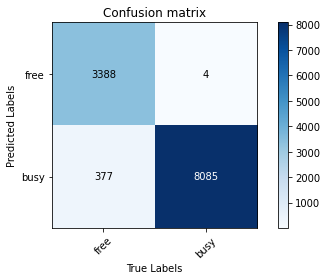

the model accuracy is  0.9678589505652101
+------+-----------+--------+-------------+
|      | Precision | Recall | Specificity |
+------+-----------+--------+-------------+
| free |   0.999   |  0.9   |     1.0     |
| busy |   0.955   |  1.0   |     0.9     |
+------+-----------+--------+-------------+


In [ ]:
# Import Library
import os
import json

import torch
from torchvision import transforms, datasets
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from torch import nn
import torch.nn.functional as F


class ConfusionMatrix(object):
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    # Update Matrix.
    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1

    # Show Result(Words)
    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("the model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity"]
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity])
        print(table)

    # Plot
    def plot(self):
        matrix = self.matrix
        # print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        # Set Xlabel
        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        # Set Ylabel
        plt.yticks(range(self.num_classes), self.labels)
        # Colorbar
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        # Add classification results into matrix
        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    Label = ['free', 'busy']
    confusion = ConfusionMatrix(num_classes=2, labels=Label)
    confusion.matrix[0, 0] = 3388
    confusion.matrix[1, 0] = 377
    confusion.matrix[1, 1] = 8085
    confusion.matrix[0, 1] = 4
    confusion.plot()
    confusion.summary()